<font size="6"> **Model Building: Feature and Algorithm Selection** </font>

In [1]:
%%capture
%run 00_mlmod_load_data.ipynb

In [2]:
KFOLDS = 3
print('Model version: ', MODEL_VERSION)

Model version:  v01


In [3]:
OUTPATH = os.path.join(io_utils.processed_path , cfg['output']['alpha_factors_ml']['folder'], MODEL_VERSION, "")

OUTFILE1 = cfg['output']['alpha_factors_ml']['preds']
print(os.path.isdir(OUTPATH))

True


In [4]:
MODEL_PATH = os.path.join(io_utils.models_path , cfg['output']['alpha_factors_ml']['folder'], MODEL_VERSION, "")

MODEL_NAME = cfg['output']['alpha_factors_ml']['model']
MODEL_METADATA = cfg['output']['alpha_factors_ml']['model_metadata']
print(os.path.isdir(MODEL_PATH))

True


In [5]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline

import pickle

from src.mle_quant_utils import mle_ensem_models as mle_ens

In [6]:
# Overwrite persisted versions of sampled data
X_train_smp = pd.read_csv(io_utils.interim_path + 'x_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = pd.read_csv(io_utils.interim_path + 'y_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = y_train_smp[target_col]

In [7]:
(y_train_smp>0).value_counts()

True     24139
False    19052
Name: target, dtype: int64

In [8]:
cv_metrics_keys = ['test_neg_root_mean_squared_error',
 'test_w_accuracy',
 'test_accuracy',
 'test_up_accuracy',
 'test_down_accuracy']
cv_metrics_cols = ['mean_' + col for col in cv_metrics_keys]
cv_mean_metrics = pd.DataFrame(columns=cv_metrics_cols, dtype=float)

In [9]:
def compute_cv_metrics(model, X, y, cv_metrics_keys=cv_metrics_keys):
    summary = pd.DataFrame(
        cross_validate(model, X, y,
                       scoring=scoring, n_jobs=-1,
                       cv=TimeSeriesSplit(n_splits=KFOLDS).split(y))
                       )[cv_metrics_keys].\
                apply(np.mean, axis=0).add_prefix("mean_")

    return summary

# Ridge

In [10]:
features1 = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed']
features2 = features1 + ['adv_20d']
features3 = features1 +  ['sector_code_-1','sector_code_0', 'sector_code_1', 'sector_code_2', 'sector_code_3', 'sector_code_4',
                          'sector_code_5', 'sector_code_6', 'sector_code_7', 'sector_code_8', 'sector_code_9', 'sector_code_10']
features4 = features1 + ['is_December', 'qtr_end', 'qtr_start']
features5 = features1 + ['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']
features6 = features1 + ['qtr_1', 'qtr_2', 'qtr_3', 'qtr_4']

In [11]:
def preds_to_df(Xs, model, colname):
    assert hasattr(model, 'predict')
    preds1 = model.predict(Xs)
    preds1 = pd.DataFrame(index=Xs.index, data=preds1, columns=[colname])
    return preds1
    

In [12]:
def get_reg_coefs(model, features):
    return pd.Series(index=features, data=model.coef_)

In [13]:
select_cols_ridge_cv_results = ['rank_test_w_accuracy', 'param_alpha', 'mean_test_w_accuracy', 'std_test_w_accuracy',
                        'mean_test_accuracy', 'mean_test_up_accuracy', 'mean_test_down_accuracy',
                         'mean_test_neg_root_mean_squared_error']

In [14]:
ridge = Ridge(fit_intercept=False, random_state=RND_SEED)

## Features Set 1: Alpha Only

In [15]:
hpgrid_ridge1 = {'alpha': [10.0**x for x in range(-4,3)]}
ridge_cv1 = GridSearchCV(ridge, hpgrid_ridge1, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_full),
                        return_train_score=True)
res_ridge_cv1 = ridge_cv1.fit(X_train_full[features1], y_train_full)

In [16]:
p_valid_mod1 = preds_to_df(X_valid_full[features1], res_ridge_cv1, 'p_valid_mod1')
res_ridge_cv1.best_score_, res_ridge_cv1.best_estimator_

(0.4109618146228529,
 Ridge(alpha=10.0, copy_X=True, fit_intercept=False, max_iter=None,
       normalize=False, random_state=123, solver='auto', tol=0.001))

In [17]:
get_reg_coefs(res_ridge_cv1.best_estimator_, features1)

Mean_Reversion_Sector_Neutral_Smoothed    0.000474
Momentum_1YR_Smoothed                     0.000100
Overnight_Sentiment_Smoothed              0.000502
dtype: float64

In [18]:
pd.DataFrame(res_ridge_cv1.cv_results_)[select_cols_ridge_cv_results]

,rank_test_w_accuracy,param_alpha,mean_test_w_accuracy,std_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
0,3,0.0001,0.410955,0.005689,0.502288,0.502782,0.501784,-0.028603
1,3,0.001,0.410955,0.005689,0.502288,0.502782,0.501784,-0.028603
2,3,0.01,0.410955,0.005689,0.502288,0.502782,0.501784,-0.028603
3,3,0.1,0.410955,0.005689,0.502288,0.502782,0.501784,-0.028603
4,3,1,0.410955,0.005689,0.502288,0.502782,0.501784,-0.028603
5,1,10,0.410962,0.005699,0.502294,0.502782,0.501798,-0.028603
6,1,100,0.410962,0.005699,0.502294,0.502782,0.501798,-0.028603


In [19]:
mod_ridge1 = Ridge(fit_intercept=False, alpha=10000)
res_ridge1 = mod_ridge1.fit(X_train_full[features1], y_train_full)
p_valid_mod1 =  preds_to_df(X_valid_full[features1], res_ridge1, 'p_valid_mod1')
get_reg_coefs(res_ridge1, features1)

Mean_Reversion_Sector_Neutral_Smoothed    0.000447
Momentum_1YR_Smoothed                     0.000094
Overnight_Sentiment_Smoothed              0.000475
dtype: float64

In [20]:
mod_ridge1 = Ridge(fit_intercept=False, alpha=1)
res_ridge1 = mod_ridge1.fit(X_train_full[features1], y_train_full)
p_valid_ridge1 =  preds_to_df(X_valid_full[features1], res_ridge1, 'p_valid_ridge1')
get_reg_coefs(res_ridge1, features1)

Mean_Reversion_Sector_Neutral_Smoothed    0.000474
Momentum_1YR_Smoothed                     0.000100
Overnight_Sentiment_Smoothed              0.000502
dtype: float64

In [21]:
cv_mean_metrics.loc['ridge1', cv_metrics_cols] = compute_cv_metrics(
    mod_ridge1, X_train_full[features1], y_train_full)

## Features Set 2: Alpha + Quant Features

In [22]:
hpgrid_ridge2 = {'alpha': [10.0**x for x in range(-1,3)]}
ridge_cv2 = GridSearchCV(ridge, hpgrid_ridge2, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_full),
                        return_train_score=True)
res_ridge_cv2 = ridge_cv2.fit(X_train_full[features2], y_train_full)

In [23]:
p_valid_mod2 =  preds_to_df(X_valid_full[features2], res_ridge_cv2, 'p_valid_mod2')
res_ridge_cv2.best_score_, res_ridge_cv2.best_estimator_

(0.4100953147996997,
 Ridge(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=None,
       normalize=False, random_state=123, solver='auto', tol=0.001))

In [24]:
get_reg_coefs(res_ridge_cv2.best_estimator_, features2)

Mean_Reversion_Sector_Neutral_Smoothed    0.000474
Momentum_1YR_Smoothed                     0.000100
Overnight_Sentiment_Smoothed              0.000502
adv_20d                                  -0.000004
dtype: float64

In [25]:
pd.DataFrame(res_ridge_cv2.cv_results_)[select_cols_ridge_cv_results]

,rank_test_w_accuracy,param_alpha,mean_test_w_accuracy,std_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
0,1,0.1,0.410095,0.005472,0.501501,0.502445,0.500321,-0.028604
1,1,1,0.410095,0.005472,0.501501,0.502445,0.500321,-0.028604
2,1,10,0.410095,0.005472,0.501501,0.502445,0.500321,-0.028604
3,4,100,0.410092,0.005453,0.501494,0.502424,0.500334,-0.028604


In [26]:
mod_ridge2 = Ridge(fit_intercept=False, alpha=1)
res_ridge2 = mod_ridge2.fit(X_train_full[features2], y_train_full)
p_valid_ridge2 =  preds_to_df(X_valid_full[features2], res_ridge2, 'p_valid_ridge2')
get_reg_coefs(res_ridge2, features2)

Mean_Reversion_Sector_Neutral_Smoothed    0.000474
Momentum_1YR_Smoothed                     0.000100
Overnight_Sentiment_Smoothed              0.000502
adv_20d                                  -0.000004
dtype: float64

In [27]:
cv_mean_metrics.loc['ridge2', cv_metrics_cols] = compute_cv_metrics(
    mod_ridge2, X_train_full[features2], y_train_full)

## Features Set 3: Alpha + Sectors

In [28]:
hpgrid_ridge3 = {'alpha': [10.0**x for x in range(-1,8)]}
ridge_cv3 = GridSearchCV(ridge, hpgrid_ridge3, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_full),
                        return_train_score=True)
res_ridge_cv3 = ridge_cv3.fit(X_train_full[features3], y_train_full)

In [29]:
p_valid_ridge3 =  preds_to_df(X_valid_full[features3], res_ridge_cv3, 'p_valid_ridge3')
res_ridge_cv3.best_score_

0.393880171353562

In [30]:
get_reg_coefs(res_ridge_cv3.best_estimator_, features3)

Mean_Reversion_Sector_Neutral_Smoothed    7.605820e-06
Momentum_1YR_Smoothed                     1.848368e-06
Overnight_Sentiment_Smoothed              8.769945e-06
sector_code_-1                            1.958652e-07
sector_code_0                             1.215250e-05
sector_code_1                             9.831731e-06
sector_code_2                             4.998922e-06
sector_code_3                             1.097825e-05
sector_code_4                             3.464816e-06
sector_code_5                             1.020148e-05
sector_code_6                             2.852971e-06
sector_code_7                             1.706206e-06
sector_code_8                             1.261468e-05
sector_code_9                             3.921960e-06
sector_code_10                            1.559683e-06
dtype: float64

In [31]:
ridge3_cv_summary_df = pd.DataFrame(res_ridge_cv3.cv_results_)[select_cols_ridge_cv_results]
ridge3_cv_summary_df

,rank_test_w_accuracy,param_alpha,mean_test_w_accuracy,std_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
0,7,0.1,0.382951,0.019851,0.551698,0.988327,0.010290,-0.028515
1,8,1,0.382943,0.019840,0.551686,0.988306,0.010290,-0.028515
2,9,10,0.382933,0.019827,0.551667,0.988252,0.010320,-0.028515
3,6,100,0.382971,0.019882,0.551674,0.988057,0.010597,-0.028512
4,5,1000,0.383288,0.020417,0.551531,0.985288,0.014005,-0.028499
5,4,10000,0.384703,0.021414,0.549658,0.964759,0.036555,-0.028490
6,3,100000,0.389542,0.020939,0.541206,0.879399,0.125163,-0.028565
7,2,1e+06,0.393643,0.016583,0.534869,0.810597,0.194720,-0.028601
8,1,1e+07,0.393880,0.015913,0.533244,0.798329,0.205882,-0.028606


In [32]:
cv_mean_metrics.loc['ridge3', cv_metrics_cols] = ridge3_cv_summary_df.loc[ridge3_cv_summary_df['rank_test_w_accuracy']==1, cv_metrics_cols].iloc[0]

## Features Set 4: Special Dates

In [33]:
hpgrid_ridge4 = {'alpha': [10.0**x for x in range(-1,6)]}
ridge_cv4 = GridSearchCV(ridge, hpgrid_ridge4, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_full),
                        return_train_score=True)
res_ridge_cv4 = ridge_cv4.fit(X_train_full[features4], y_train_full)

In [34]:
p_valid_mod4 =  preds_to_df(X_valid_full[features4], res_ridge_cv4, 'p_valid_mod4')
res_ridge_cv4.best_score_, res_ridge_cv4.best_estimator_

(0.41352853676058077,
 Ridge(alpha=100.0, copy_X=True, fit_intercept=False, max_iter=None,
       normalize=False, random_state=123, solver='auto', tol=0.001))

In [35]:
get_reg_coefs(res_ridge_cv4.best_estimator_, features4)

Mean_Reversion_Sector_Neutral_Smoothed    0.000474
Momentum_1YR_Smoothed                     0.000100
Overnight_Sentiment_Smoothed              0.000501
is_December                               0.005427
qtr_end                                   0.001491
qtr_start                                -0.007862
dtype: float64

In [36]:
pd.DataFrame(res_ridge_cv4.cv_results_)[select_cols_ridge_cv_results]

,rank_test_w_accuracy,param_alpha,mean_test_w_accuracy,std_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
0,2,0.1,0.413517,0.004804,0.504626,0.503689,0.506221,-0.028623
1,2,1,0.413517,0.004804,0.504626,0.503689,0.506221,-0.028623
2,2,10,0.413517,0.004804,0.504626,0.503689,0.506221,-0.028622
3,1,100,0.413529,0.004816,0.504632,0.503667,0.506264,-0.028617
4,5,1000,0.413330,0.005046,0.504459,0.503668,0.505881,-0.028602
5,6,10000,0.412431,0.005210,0.503652,0.503356,0.504193,-0.028600
6,7,100000,0.411537,0.005061,0.502784,0.502731,0.502981,-0.028602


In [37]:
mod_ridge4 = Ridge(fit_intercept=False, alpha=10)
res_ridge4 = mod_ridge4.fit(X_train_full[features4], y_train_full)
p_valid_ridge4 =  preds_to_df(X_valid_full[features4], res_ridge4, 'p_valid_ridge4')
get_reg_coefs(res_ridge4, features4)

Mean_Reversion_Sector_Neutral_Smoothed    0.000474
Momentum_1YR_Smoothed                     0.000100
Overnight_Sentiment_Smoothed              0.000502
is_December                               0.005474
qtr_end                                   0.001529
qtr_start                                -0.008108
dtype: float64

In [38]:
cv_mean_metrics.loc['ridge4', cv_metrics_cols] = compute_cv_metrics(
    mod_ridge4, X_train_full[features4], y_train_full)

## Features Set 5: Weekday

In [39]:
hpgrid_ridge5 = {'alpha': [10.0**x for x in range(-1,8)]}
ridge_cv5 = GridSearchCV(ridge, hpgrid_ridge5, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_full),
                        return_train_score=True)
res_ridge_cv5 = ridge_cv5.fit(X_train_full[features5], y_train_full)

In [40]:
p_valid_ridge5 =  preds_to_df(X_valid_full[features5], res_ridge_cv5, 'p_valid_ridge5')
res_ridge_cv5.best_score_, res_ridge_cv5.best_estimator_

(0.38686431973859164,
 Ridge(alpha=10000000.0, copy_X=True, fit_intercept=False, max_iter=None,
       normalize=False, random_state=123, solver='auto', tol=0.001))

In [41]:
get_reg_coefs(res_ridge_cv5.best_estimator_, features5)

Mean_Reversion_Sector_Neutral_Smoothed    0.000008
Momentum_1YR_Smoothed                     0.000002
Overnight_Sentiment_Smoothed              0.000009
weekday_0                                 0.000020
weekday_1                                 0.000013
weekday_2                                 0.000016
weekday_3                                 0.000016
weekday_4                                 0.000010
dtype: float64

In [42]:
pd.DataFrame(res_ridge_cv5.cv_results_)[select_cols_ridge_cv_results]

,rank_test_w_accuracy,param_alpha,mean_test_w_accuracy,std_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
0,5,0.1,0.383138,0.018824,0.553745,1.000000,0.000000,-0.028512
1,5,1,0.383138,0.018824,0.553745,1.000000,0.000000,-0.028512
2,5,10,0.383138,0.018824,0.553745,1.000000,0.000000,-0.028512
3,5,100,0.383138,0.018824,0.553745,1.000000,0.000000,-0.028510
4,5,1000,0.383138,0.018824,0.553745,1.000000,0.000000,-0.028501
5,4,10000,0.383230,0.018940,0.553596,0.998552,0.001632,-0.028477
6,3,100000,0.383683,0.018757,0.549975,0.973471,0.026585,-0.028546
7,2,1e+06,0.386149,0.016981,0.546421,0.933420,0.068126,-0.028597
8,1,1e+07,0.386864,0.016656,0.545863,0.924812,0.077291,-0.028605


In [43]:
mod_ridge5 = Ridge(fit_intercept=False, alpha=1e6)
res_ridge5 = mod_ridge5.fit(X_train_full[features5], y_train_full)
p_valid_mod5 = preds_to_df(X_valid_full[features5], res_ridge5, 'p_valid_mod5')
get_reg_coefs(res_ridge5, features5)

Mean_Reversion_Sector_Neutral_Smoothed    0.000067
Momentum_1YR_Smoothed                     0.000016
Overnight_Sentiment_Smoothed              0.000076
weekday_0                                 0.000195
weekday_1                                 0.000122
weekday_2                                 0.000153
weekday_3                                 0.000151
weekday_4                                 0.000096
dtype: float64

In [44]:
cv_mean_metrics.loc['ridge5', cv_metrics_cols] = compute_cv_metrics(
    mod_ridge5, X_train_full[features5], y_train_full)

## Features Set 6: Quarter

In [45]:
hpgrid_ridge6 = {'alpha': [10.0**x for x in range(-1,6)]}
ridge_cv6 = GridSearchCV(ridge, hpgrid_ridge6, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_full),
                        return_train_score=True)
res_ridge_cv6 = ridge_cv6.fit(X_train_full[features6], y_train_full)

In [46]:
p_valid_ridge6 =  preds_to_df(X_valid_full[features6], res_ridge_cv6, 'p_valid_ridge6')
res_ridge_cv6.best_score_, res_ridge_cv6.best_estimator_

(0.3876591242954706,
 Ridge(alpha=10000.0, copy_X=True, fit_intercept=False, max_iter=None,
       normalize=False, random_state=123, solver='auto', tol=0.001))

In [47]:
get_reg_coefs(res_ridge_cv6.best_estimator_, features6)

Mean_Reversion_Sector_Neutral_Smoothed    0.000445
Momentum_1YR_Smoothed                     0.000083
Overnight_Sentiment_Smoothed              0.000475
qtr_1                                     0.004203
qtr_2                                     0.003007
qtr_3                                     0.001599
qtr_4                                     0.003005
dtype: float64

In [48]:
ridge6_cv_summary_df = pd.DataFrame(res_ridge_cv6.cv_results_)[select_cols_ridge_cv_results]
ridge6_cv_summary_df

,rank_test_w_accuracy,param_alpha,mean_test_w_accuracy,std_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
0,3,0.1,0.387523,0.024483,0.532301,0.848905,0.156301,-0.028671
1,3,1,0.387523,0.024483,0.532301,0.848905,0.156301,-0.028671
2,3,10,0.387523,0.024483,0.532301,0.848905,0.156301,-0.028671
3,3,100,0.387523,0.024483,0.532301,0.848905,0.156301,-0.028670
4,2,1000,0.387553,0.024523,0.532339,0.848969,0.156301,-0.028659
5,1,10000,0.387659,0.024663,0.532432,0.848980,0.156507,-0.028596
6,7,100000,0.387394,0.024171,0.531830,0.846381,0.158268,-0.028567


In [49]:
cv_mean_metrics.loc['ridge6', cv_metrics_cols] = ridge6_cv_summary_df.loc[ridge6_cv_summary_df['rank_test_w_accuracy']==1, cv_metrics_cols].iloc[0]

## Nov Samples

In [50]:
ridge_base = Ridge(fit_intercept=False, alpha=1)
ridge_nov1 = mle_ens.NoOverlapVoterRegressor(base_estimator=ridge_base, n_skip_samples=4)
ridge_nov1.fit(X_train_full[features1], y_train_full)
p_valid_ridge_nov1 =  preds_to_df(X_valid_full[features1], ridge_nov1, 'p_valid_ridge_nov1')

In [51]:
ridge_nov2 = mle_ens.NoOverlapVoterRegressor(base_estimator=ridge_base, n_skip_samples=4)
ridge_nov2.fit(X_train_full[features2], y_train_full)
p_valid_ridge_nov2 =  preds_to_df(X_valid_full[features2], ridge_nov2, 'p_valid_ridge_nov2')

## Feature Interaction

In [52]:
poly = PolynomialFeatures(include_bias=False, interaction_only=True)
selector = SelectKBest(mutual_info_regression)
ridge = Ridge(fit_intercept=False)
pipe = Pipeline([('preprocessor', poly), ('selector', selector), ('regressor', ridge)])

In [53]:
hp_pipe= {'regressor__alpha': [10.0**x for x in range(-1,3)],
               'selector__k': [3, 4, 5]}
pipe_cv = GridSearchCV(pipe, hp_pipe, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_full),
                        return_train_score=True)
#res_pipe_cv = pipe_cv.fit(X_train_full[features2], y_train_full)

In [54]:
#p_valid_xfeat =  preds_to_df(X_valid_full[features2], res_pipe_cv, 'p_valid_xfeat')
#ridge_pol_cv2.best_score_, ridge_pol_cv2.best_estimator_

In [55]:
#ridge_pol_cv2.best_estimator_.named_steps.regressor.coef_

# Neural Networks

In [56]:
select_cols_mlp_cv_results = ['rank_test_w_accuracy', 'param_alpha', 'param_hidden_layer_sizes', 'param_learning_rate_init', 'param_max_iter',
                             'mean_test_w_accuracy', 'std_test_w_accuracy','mean_test_accuracy',
                              'mean_test_up_accuracy', 'mean_test_down_accuracy', 'mean_test_neg_root_mean_squared_error']

## Features Set 1: Alpha Only

In [57]:
hpgrid_mlp1 = {'hidden_layer_sizes': [(1,), (3,)],
              'alpha': [10.0**x for x in range(-2, 1)],
             'learning_rate_init': [0.001],
             'max_iter': [50, 100],
             }
mlp = MLPRegressor(solver='adam', shuffle=False, activation='relu', batch_size=500, random_state=RND_SEED)

mlp_cv1 = GridSearchCV(mlp, hpgrid_mlp1, scoring=scoring,
                        n_jobs=-1, refit='accuracy',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_full),
                        return_train_score=True)
res_mlp_cv1 = mlp_cv1.fit(X_train_full[features1], y_train_full)

In [58]:
p_valid_mlp1 =  preds_to_df(X_valid_full[features1], res_mlp_cv1, 'p_valid_mlp1')
res_mlp_cv1.best_score_, res_mlp_cv1.best_estimator_

(0.5537448375934814,
 MLPRegressor(activation='relu', alpha=0.01, batch_size=500, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=50, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=123, shuffle=False, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False))

In [59]:
mlp1_cv_summary_df = pd.DataFrame(res_mlp_cv1.cv_results_)[select_cols_mlp_cv_results].sort_values(by='mean_test_w_accuracy')
mlp1_cv_summary_df

,rank_test_w_accuracy,param_alpha,param_hidden_layer_sizes,param_learning_rate_init,param_max_iter,mean_test_w_accuracy,std_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
0,7,0.01,"(1,)",0.001,50,0.383138,0.018824,0.553745,1.000000,0.000000,-0.028584
1,7,0.01,"(1,)",0.001,100,0.383138,0.018824,0.553745,1.000000,0.000000,-0.028584
4,7,0.1,"(1,)",0.001,50,0.383138,0.018824,0.553745,1.000000,0.000000,-0.028582
5,7,0.1,"(1,)",0.001,100,0.383138,0.018824,0.553745,1.000000,0.000000,-0.028582
8,7,1,"(1,)",0.001,50,0.383138,0.018824,0.553745,1.000000,0.000000,-0.028565
9,7,1,"(1,)",0.001,100,0.383138,0.018824,0.553745,1.000000,0.000000,-0.028565
6,5,0.1,"(3,)",0.001,50,0.386276,0.022094,0.510145,0.723005,0.275138,-0.030033
7,5,0.1,"(3,)",0.001,100,0.386276,0.022094,0.510145,0.723005,0.275138,-0.030033
2,3,0.01,"(3,)",0.001,50,0.387872,0.019355,0.511249,0.715935,0.283643,-0.030263
3,3,0.01,"(3,)",0.001,100,0.387872,0.019355,0.511249,0.715935,0.283643,-0.030263


In [60]:
cv_mean_metrics.loc['mlp1', cv_metrics_cols] = mlp1_cv_summary_df.loc[mlp1_cv_summary_df['rank_test_w_accuracy']==1, cv_metrics_cols].iloc[0]

## Features Set 2: Alpha + Quant Features

In [61]:
hpgrid_mlp2 = {'hidden_layer_sizes': [(1,), (5,), (1,5,)],
              'alpha': [10.0**x for x in range(-2, 1)],
             'learning_rate_init': [0.001],
             'max_iter': [25, 50],
             }
mlp_cv2 = GridSearchCV(mlp, hpgrid_mlp2, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_full),
                        return_train_score=True)
res_mlp_cv2 = mlp_cv2.fit(X_train_full[features2], y_train_full)

In [62]:
p_valid_mlp2 =  preds_to_df(X_valid_full[features2], res_mlp_cv2, 'p_valid_mlp2')
res_mlp_cv2.best_score_, res_mlp_cv2.best_estimator_

(0.39745390780454287,
 MLPRegressor(activation='relu', alpha=0.01, batch_size=500, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=25, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=123, shuffle=False, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False))

In [63]:
mlp2_cv_summary_df = pd.DataFrame(res_mlp_cv2.cv_results_)[select_cols_mlp_cv_results].sort_values(by='mean_test_w_accuracy')
mlp2_cv_summary_df

,rank_test_w_accuracy,param_alpha,param_hidden_layer_sizes,param_learning_rate_init,param_max_iter,mean_test_w_accuracy,std_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
11,18,0.1,"(1, 5)",0.001,50,0.384534,0.020592,0.542713,0.926131,0.075115,-0.028547
5,17,0.01,"(1, 5)",0.001,50,0.384672,0.020769,0.542682,0.925176,0.076350,-0.028549
17,16,1,"(1, 5)",0.001,50,0.384686,0.020787,0.544381,0.935182,0.066661,-0.028539
15,14,1,"(5,)",0.001,50,0.386377,0.018978,0.526826,0.815663,0.182637,-0.030444
14,14,1,"(5,)",0.001,25,0.386377,0.018978,0.526826,0.815663,0.182637,-0.030444
16,13,1,"(1, 5)",0.001,25,0.386820,0.023557,0.537163,0.881003,0.123824,-0.028692
4,12,0.01,"(1, 5)",0.001,25,0.387265,0.024143,0.536983,0.877625,0.128029,-0.028691
10,11,0.1,"(1, 5)",0.001,25,0.387290,0.024176,0.537052,0.877893,0.127823,-0.028691
13,9,1,"(1,)",0.001,50,0.388154,0.013370,0.550713,0.942023,0.058947,-0.028552
12,9,1,"(1,)",0.001,25,0.388154,0.013370,0.550713,0.942023,0.058947,-0.028552


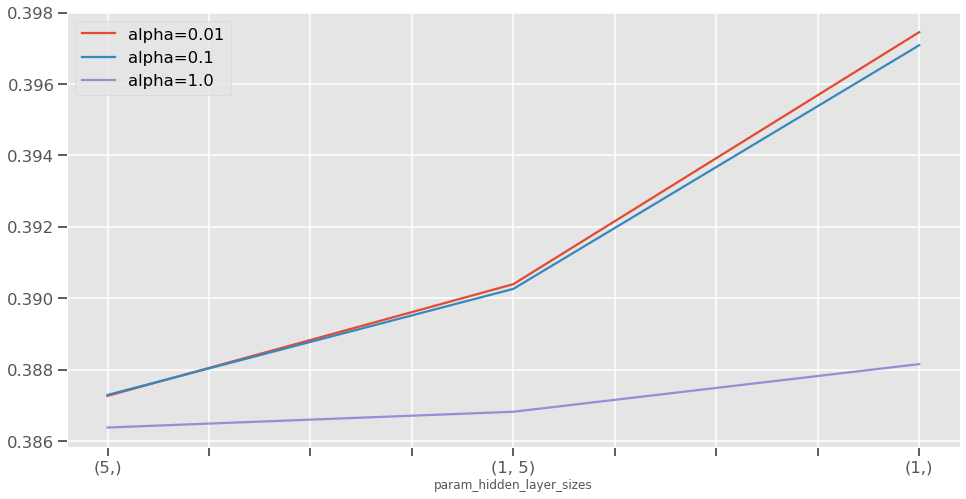

In [64]:
mlp2_mask = (mlp2_cv_summary_df['param_max_iter'] == 25)

ax = mlp2_cv_summary_df[mlp2_mask & (mlp2_cv_summary_df['param_alpha'] == 0.01)].sort_values(by='mean_test_w_accuracy').plot(
    x='param_hidden_layer_sizes', y='mean_test_w_accuracy', label='alpha=0.01')
mlp2_cv_summary_df[mlp2_mask & (mlp2_cv_summary_df['param_alpha'] == 0.1)].sort_values(by='mean_test_w_accuracy').plot(
    x='param_hidden_layer_sizes', y='mean_test_w_accuracy', label='alpha=0.1', ax=ax)
mlp2_cv_summary_df[mlp2_mask & (mlp2_cv_summary_df['param_alpha'] == 1.0)].sort_values(by='mean_test_w_accuracy').plot(
    x='param_hidden_layer_sizes', y='mean_test_w_accuracy', label='alpha=1.0', ax=ax)

plt.show()

In [65]:
cv_mean_metrics.loc['mlp2', cv_metrics_cols] = mlp2_cv_summary_df.loc[mlp2_cv_summary_df['rank_test_w_accuracy']==1, cv_metrics_cols].iloc[0]

# Random Forest

In [66]:
select_cols_rf_cv_results = ['rank_test_w_accuracy',
 'param_max_depth', 'param_max_features', 'param_max_samples',
 'mean_test_w_accuracy',
 'std_test_w_accuracy',
 'mean_test_accuracy',
 'mean_test_up_accuracy',
 'mean_test_down_accuracy',
 'mean_test_neg_root_mean_squared_error']

## Features Set 1: Alpha Only

In [67]:
hpgrid_rf1 = {'max_samples': [0.25, 0.5, 0.75],
            'max_features': [1.],
            'max_depth': [3, 5]}

In [68]:
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)

In [69]:
rf_cv1 = GridSearchCV(rf, hpgrid_rf1, scoring=scoring,
                      n_jobs=-1, refit='w_accuracy',
                      cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_full),
                      return_train_score=True)
res_rf_cv1 = rf_cv1.fit(X_train_full[features1], y_train_full)

In [70]:
p_valid_rf1 =  preds_to_df(X_valid_full[features1], res_rf_cv1, 'p_valid_rf1')
res_rf_cv1.best_score_, res_rf_cv1.best_estimator_

(0.3830988595787026,
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=3, max_features=1.0, max_leaf_nodes=None,
                       max_samples=0.25, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=123, verbose=0, warm_start=False))

In [71]:
rf1_cv_summary_df = pd.DataFrame(res_rf_cv1.cv_results_)[select_cols_rf_cv_results]
rf1_cv_summary_df

,rank_test_w_accuracy,param_max_depth,param_max_features,param_max_samples,mean_test_w_accuracy,std_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
0,1,3,1,0.25,0.383099,0.018731,0.553646,0.999614,0.000263,-0.028502
1,3,3,1,0.5,0.383066,0.018692,0.553596,0.999516,0.000276,-0.028503
2,2,3,1,0.75,0.383073,0.018729,0.553621,0.999624,0.000191,-0.028506
3,4,5,1,0.25,0.383012,0.018575,0.553243,0.997647,0.001906,-0.028521
4,6,5,1,0.5,0.382910,0.018461,0.553050,0.997128,0.002180,-0.028536
5,5,5,1,0.75,0.382968,0.018408,0.553063,0.996800,0.002602,-0.028538


In [72]:
cv_mean_metrics.loc['rf1', cv_metrics_cols] = rf1_cv_summary_df.loc[rf1_cv_summary_df['rank_test_w_accuracy']==1, cv_metrics_cols].iloc[0]

# Benchmark

In [73]:
def compute_acc_metrics_by_feature(data, features):
    alphas_acc = pd.DataFrame(columns=['wacc', 'acc', 'acc_up', 'acc_down'], dtype=float)
   
    for alpha_fac in features:
        alphas_acc.loc[alpha_fac, 'wacc'] = mle_utils.direction_accuracy_func(
            y_true=data[target_col], y_pred=data[alpha_fac], kind='weighted', w_fp=2., w_fn=1.)
        alphas_acc.loc[alpha_fac, 'acc'] = mle_utils.direction_accuracy_func(
            y_true=data[target_col], y_pred=data[alpha_fac], kind='global')
        alphas_acc.loc[alpha_fac, 'acc_up'] = mle_utils.direction_accuracy_func(
            y_true=data[target_col], y_pred=data[alpha_fac], kind='upwards')
        alphas_acc.loc[alpha_fac, 'acc_down'] = mle_utils.direction_accuracy_func(
            y_true=data[target_col], y_pred=data[alpha_fac], kind='downwards')
        
    return alphas_acc


In [74]:
benchmark_val_preds = [p_valid_ridge1, p_valid_ridge2, p_valid_ridge3, p_valid_ridge4, p_valid_ridge5, p_valid_ridge6,
                       p_valid_ridge_nov1, p_valid_ridge_nov2, p_valid_mlp1, p_valid_mlp2, p_valid_rf1]
all_models_p_valid = pd.concat(benchmark_val_preds + [y_valid_full], axis=1)
all_models_p_valid_cols = all_models_p_valid.filter(regex='^p_valid').columns.tolist()
benchmark_val_acc = compute_acc_metrics_by_feature(all_models_p_valid, all_models_p_valid_cols)

In [75]:
benchmark_val_acc.index

Index(['p_valid_ridge1', 'p_valid_ridge2', 'p_valid_ridge3', 'p_valid_ridge4',
       'p_valid_ridge5', 'p_valid_ridge6', 'p_valid_ridge_nov1',
       'p_valid_ridge_nov2', 'p_valid_mlp1', 'p_valid_mlp2', 'p_valid_rf1'],
      dtype='object')

In [76]:
unprefix_benchmark_val_acc_filt = [col for col in benchmark_val_acc.index if col[len('p_valid_'):] in cv_mean_metrics.index]
#benchmark_val_acc_cp = benchmark_val_acc.loc[unprefix_benchmark_val_acc_filt].copy()
#unprefix_benchmark_val_acc_cp = [col[len('p_valid_'):] for col in benchmark_val_acc_cp.index]

benchmark_val_acc_cp = benchmark_val_acc.copy()
unprefix_benchmark_val_acc_cp = [col[len('p_valid_'):] for col in benchmark_val_acc.index]

benchmark_val_acc_cp['kind'] = 'valid'
benchmark_val_acc_cp['model'] = unprefix_benchmark_val_acc_cp

In [77]:
benchmark_val_acc_cp

,wacc,acc,acc_up,acc_down,kind,model
p_valid_ridge1,0.414210,0.503953,0.504446,0.503315,valid,ridge1
p_valid_ridge2,0.413944,0.503691,0.504250,0.502968,valid,ridge2
p_valid_ridge3,0.406421,0.543726,0.789926,0.225516,valid,ridge3
p_valid_ridge4,0.395130,0.496350,0.561044,0.412736,valid,ridge4
p_valid_ridge5,0.395623,0.552484,0.909497,0.091053,valid,ridge5
p_valid_ridge6,0.392555,0.563791,1.000000,0.000000,valid,ridge6
p_valid_ridge_nov1,0.414142,0.503897,0.504470,0.503157,valid,ridge_nov1
p_valid_ridge_nov2,0.414137,0.503897,0.504495,0.503126,valid,ridge_nov2
p_valid_mlp1,0.436177,0.436195,0.000049,0.999905,valid,mlp1
p_valid_mlp2,0.436170,0.439762,0.020910,0.981120,valid,mlp2


In [78]:
cv_mean_metrics_cp = cv_mean_metrics.rename(columns={'mean_test_w_accuracy': 'wacc',
                        'mean_test_accuracy': 'acc',
                        'mean_test_up_accuracy': 'acc_up',
                        'mean_test_down_accuracy': 'acc_down'})
cv_mean_metrics_cp['kind'] = 'cv_average'
cv_mean_metrics_cp['model'] = cv_mean_metrics_cp.index

In [79]:
assessment_panel = pd.concat([cv_mean_metrics_cp, benchmark_val_acc_cp], axis=0)

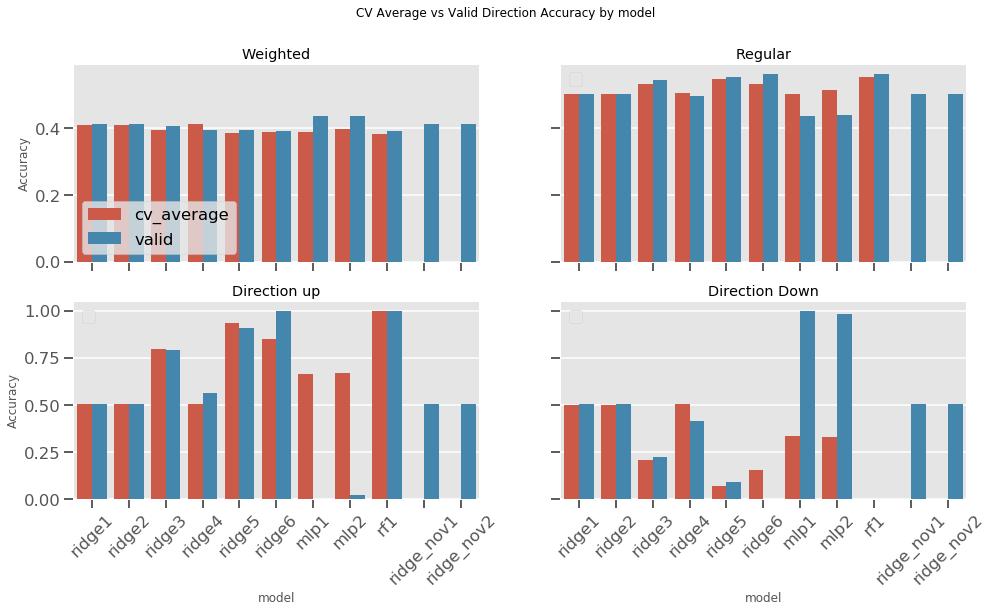

In [80]:
fig, axs = plt.subplots(2,2, sharex=True, sharey='row')
plt.suptitle("CV Average vs Valid Direction Accuracy by model")

ax1 = axs[0,0]
sns.barplot(data=assessment_panel, x='model', y='wacc', hue='kind', ax=ax1)
ax1.set_title('Weighted')
ax1.set_xlabel('')
ax1.set_ylabel('Accuracy')

ax2 = axs[0,1]
sns.barplot(data=assessment_panel, x='model', y='acc', hue='kind', ax=ax2)
ax2.set_title('Regular')
ax2.set_xlabel('')
ax2.set_ylabel('')

ax3 = axs[1,0]
sns.barplot(data=assessment_panel, x='model', y='acc_up', hue='kind', ax=ax3)
ax3.set_title('Direction up')
ax3.set_ylabel('Accuracy')
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)
    
ax4 = axs[1,1]
sns.barplot(data=assessment_panel, x='model', y='acc_down', hue='kind', ax=ax4)
ax4.set_title('Direction Down')
ax4.set_ylabel('')
for tick in ax4.get_xticklabels():
    tick.set_rotation(45)
    
for ax in axs.reshape(-1)[1:]:
    ax.legend("")
axs[0,0].legend(loc='lower left')

plt.show()

MLP models achieve the best CV performance, however, it is a good practice to compare this mean CV Error with an error metric computed in a holdout dataset (valid). In this case, MLP1 model excels at Accuracy Direction Down, but predicts no Direction Up. On the other hand, MLP2 directional accuracies are skewed, more noticiably in valid dataset 

The most robust models are ridge1 or ridge2, adding more features strongly skews coefficient values, that's it, other features are assigned a set of values much higher than alpha factors; however, this does not leads to an improvement on CV Average scorings, in addition, these models are not performing well in out-of-sample, therefore, these other features introduce patterns that strongly chagnes over time.
As an overfitting problem, it can be dealt in two ways:
* Adding strong regularization: Which is not efficient, because alpha factors coefficients are also shrinked
* Getting more data, although patterns may not extrapolate in time


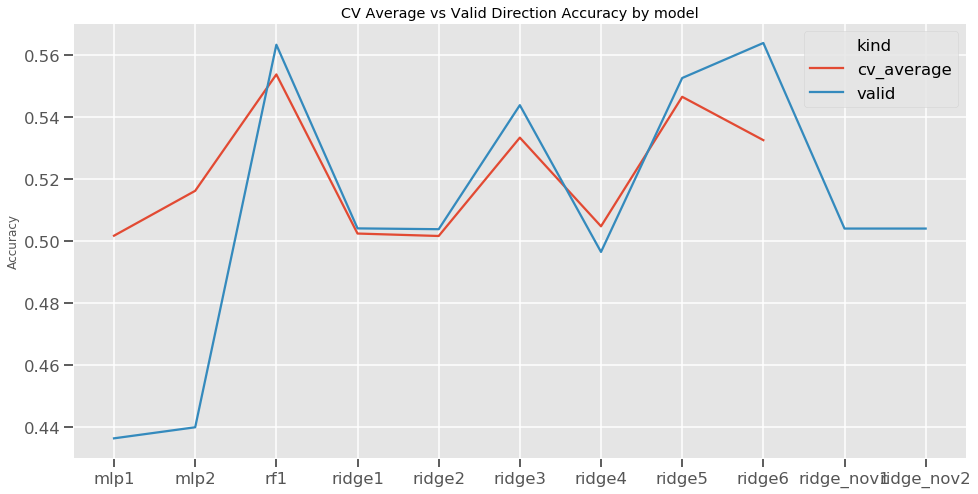

In [107]:
ax1 = sns.lineplot(data=assessment_panel, x='model', y='acc', hue='kind', order = '')
ax1.set_title('CV Average vs Valid Direction Accuracy by model')
ax1.set_xlabel('')
ax1.set_ylabel('Accuracy')

for tick in ax4.get_xticklabels():
    tick.set_rotation(45)
    
for ax in axs.reshape(-1)[1:]:
    ax.legend("")
axs[0,0].legend(loc='lower left')

plt.show()

# Refit Champion Model on Train + Valid

In [81]:
mod_ridge1

Ridge(alpha=1, copy_X=True, fit_intercept=False, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [82]:
champ_train_coefs = get_reg_coefs(res_ridge1, features1)
champ_train_coefs.name = 'train'
champ_train_coefs

Mean_Reversion_Sector_Neutral_Smoothed    0.000474
Momentum_1YR_Smoothed                     0.000100
Overnight_Sentiment_Smoothed              0.000502
Name: train, dtype: float64

In [83]:
champ_model = mod_ridge1
res_champ_model = champ_model.fit(pd.concat([X_train_full, X_valid_full], axis=0)[features1],
                pd.concat([y_train_full, y_valid_full], axis=0))

In [84]:
champ_valid_coefs = get_reg_coefs(champ_model, features1)
champ_valid_coefs.name = 'valid'
champ_valid_coefs

Mean_Reversion_Sector_Neutral_Smoothed    0.000480
Momentum_1YR_Smoothed                     0.000167
Overnight_Sentiment_Smoothed              0.000373
Name: valid, dtype: float64

In [120]:
champ_acc = assessment_panel.loc[['ridge1', 'p_valid_ridge1'], ['acc']]
champ_acc = champ_acc.rename({'ridge1': 'cv-average', 'p_valid_ridge1': 'valid'})

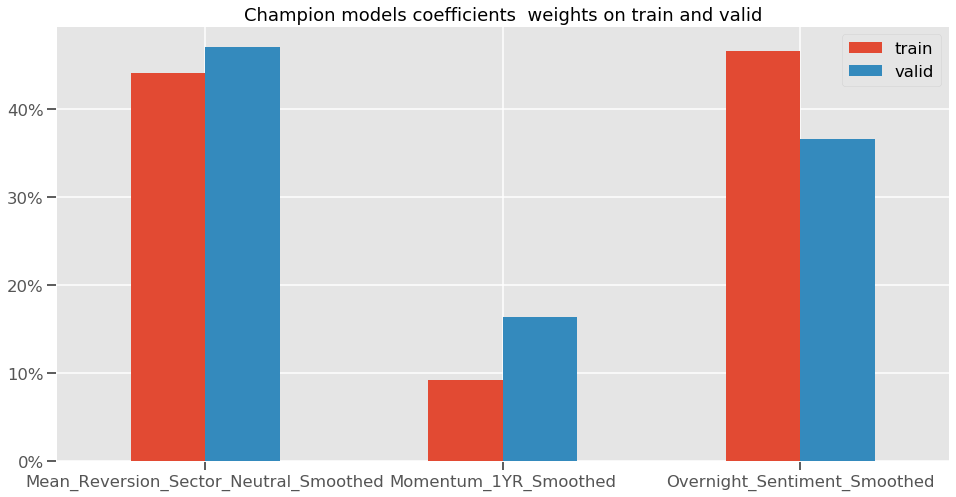

In [195]:
champ_coefs = pd.concat([champ_train_coefs, champ_valid_coefs ], axis=1)
ax = (champ_coefs/champ_coefs.sum(axis=0)).plot.bar()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.xticks(rotation=0)
plt.title("Champion models coefficients  weights on train and valid", fontsize=18)
plt.show()

In [86]:
p_test_champ = preds_to_df(X_test_full[features1], res_ridge1, 'p_test_champ')

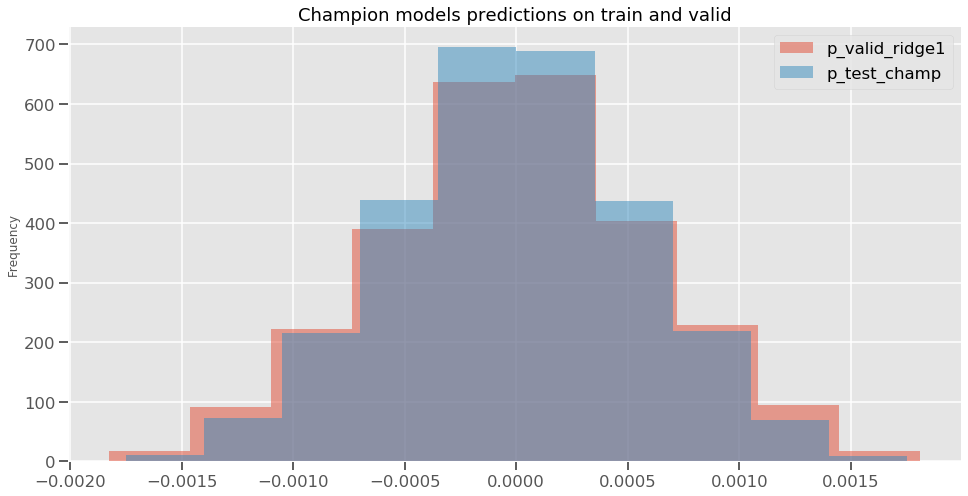

In [126]:
ax = p_valid_ridge1.plot.hist(alpha=0.5, density=True)
p_test_champ.plot.hist(alpha=0.5, density=True, ax=ax)
plt.title("Champion models predictions on train and valid", fontsize=18)
plt.show()

In [88]:
champ_test_acc = compute_acc_metrics_by_feature(p_test_champ.join(y_test_full), ['p_test_champ'])
champ_test_acc

,wacc,acc,acc_up,acc_down
p_test_champ,0.40332,0.502383,0.501397,0.50339


In [89]:
acc_cols = ['wacc', 'acc', 'acc_up', 'acc_down']
champ_traincv_acc = cv_mean_metrics_cp.loc['ridge1'][acc_cols].to_frame('cv_train_champ').T
champ_traincv_acc

,wacc,acc,acc_up,acc_down
cv_train_champ,0.410955,0.502288,0.502782,0.501784


In [90]:
champ_valid_acc = benchmark_val_acc_cp.loc['p_valid_ridge1'][acc_cols].to_frame('valid_champ').T
champ_valid_acc

,wacc,acc,acc_up,acc_down
valid_champ,0.41421,0.503953,0.504446,0.503315


In [91]:
champ_acc_summary = pd.concat([champ_traincv_acc, champ_valid_acc, champ_test_acc], axis=0)
champ_acc_summary

,wacc,acc,acc_up,acc_down
cv_train_champ,0.410955,0.502288,0.502782,0.501784
valid_champ,0.41421,0.503953,0.504446,0.503315
p_test_champ,0.40332,0.502383,0.501397,0.50339


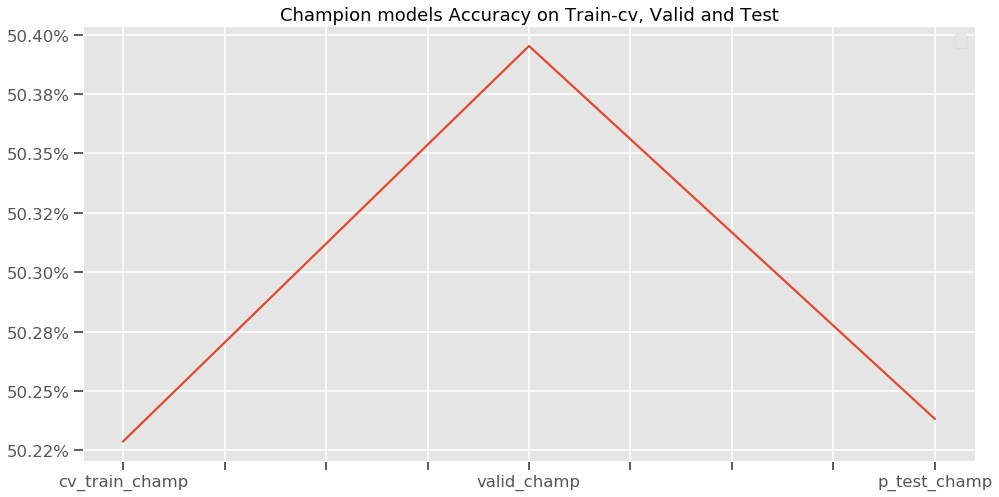

In [131]:
ax = champ_acc_summary.plot(y='acc', label='Accuracy')
ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
plt.title("Champion models Accuracy on Train-cv, Valid and Test", fontsize=18)
plt.legend("")
plt.show()

# Write Champion Model 

## Compute alpha factor from ml model predictions
* (Optional) Sector neutralization
* ranking
* z-scoring

In [93]:
all_alphas = features1

In [158]:
ml_alpha_test = mle_utils.get_pred_alpha(p_test_champ, kind='reg')
ml_alpha_test_sector = ml_alpha_test.join(sector_factor_df,how='left')
ml_alpha_test_sector.head(5)

p_test_champ  sector_code
date                      asset                           
2015-05-26 00:00:00+00:00 A          0.000961            0
                          AAL        0.001474            3
                          AAP       -0.001072            8
                          AAPL       0.000003            1
                          ABBV       0.000448            0

In [161]:
ml_alpha_test_sector_means = ml_alpha_test_sector.reset_index().set_index(['date', 'sector_code']).groupby(level=[0, 1])[['p_test_champ']].transform(np.mean)
ml_alpha_test_sector_means['asset'] = ml_alpha_test_sector.index.get_level_values(1)
ml_alpha_test_sector_means = ml_alpha_test_sector_means.reset_index().set_index(['date', 'asset'])
ml_alpha_test_sector_means.head(5)

sector_code  p_test_champ
date                      asset                           
2015-05-26 00:00:00+00:00 A                0      0.000141
                          AAL              3     -0.000101
                          AAP              8      0.000195
                          AAPL             1      0.000142
                          ABBV             0      0.000141

In [163]:
ml_alpha_test_neu = ml_alpha_test - ml_alpha_test_sector_means[['p_test_champ']]
ml_alpha_test_neu.head()

p_test_champ
date                      asset              
2015-05-26 00:00:00+00:00 A          0.000819
                          AAL        0.001575
                          AAP       -0.001267
                          AAPL      -0.000139
                          ABBV       0.000307

In [175]:
avg_combi_alpha_test = X_test_full[all_alphas].mean(axis=1)
avg_combi_alpha_test.name = 'avg_combi_alpha'
ml_alpha_test_zscored =mle_utils.get_factor_alpha(ml_alpha_test_neu.iloc[:,0], bins=9)
ml_alpha_test_zscored.name = 'ml_alpha'

## Comparison with average alpha factor

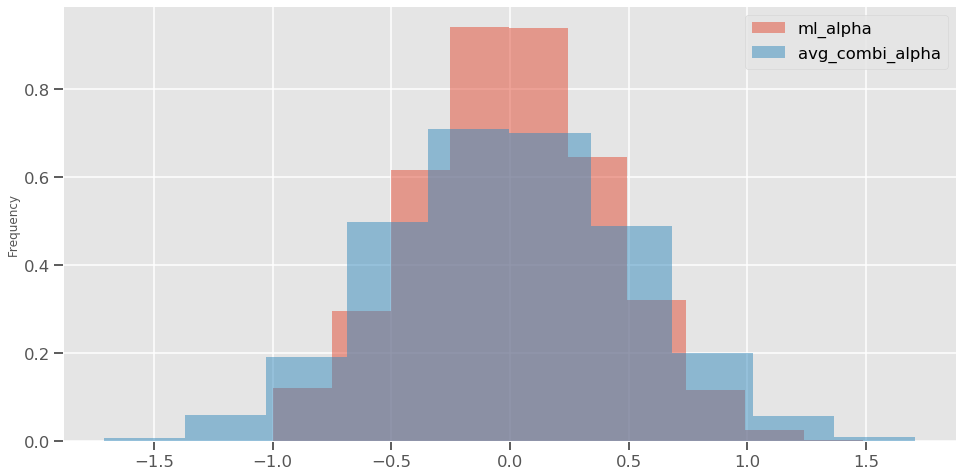

In [166]:
ax = ml_alpha_test_zscored.plot.hist(alpha=0.5, density=True, label='ml_alpha')
avg_combi_alpha_test.plot.hist(alpha=0.5, density=True, label='avg_combi_alpha',  ax=ax)
plt.legend()
plt.show()

In [173]:
avg_combi_alpha_test.head()

date                       asset
2015-05-26 00:00:00+00:00  A        0.483467
                           AAL      1.197722
                           AAP     -0.734169
                           AAPL     0.421095
                           ABBV     0.151598
dtype: float64

In [172]:
ml_alpha_test_zscored.head()

date                       asset
2015-05-26 00:00:00+00:00  A        0.441308
                           AAL      0.921743
                           AAP     -0.759782
                           AAPL    -0.039128
                           ABBV     0.201090
Name: p_test_champ, dtype: float64

In [177]:
pd.concat([avg_combi_alpha_test, ml_alpha_test_zscored, y_test_full], axis=1).corr()

,avg_combi_alpha,ml_alpha,target
avg_combi_alpha,1.000000,0.831029,0.033375
ml_alpha,0.831029,1.000000,0.017367
target,0.033375,0.017367,1.000000


## Wrap data to write

In [167]:
preds = p_test_champ.rename(columns={'p_test_champ': 'p_test'})
preds['ml_alpha_raw'] = ml_alpha_test
preds['ml_alpha_sector_neutral'] = ml_alpha_test_neu
preds['ml_alpha'] = ml_alpha_test_zscored
preds['avg_combi_alpha'] = avg_combi_alpha_test
preds[all_alphas] = X_test_full[all_alphas] 

pd.concat([preds.head(2), preds.tail(2)], axis=0)

p_test  ml_alpha_raw  \
date                      asset                           
2015-05-26 00:00:00+00:00 A      0.000961      0.000961   
                          AAL    0.001474      0.001474   
2015-12-28 00:00:00+00:00 ZION   0.000835      0.000835   
                          ZTS   -0.000254     -0.000254   

                                 ml_alpha_sector_neutral  ml_alpha  \
date                      asset                                      
2015-05-26 00:00:00+00:00 A                     0.000819  0.441308   
                          AAL                   0.001575  0.921743   
2015-12-28 00:00:00+00:00 ZION                  0.000687  0.561338   
                          ZTS                  -0.000176 -0.219331   

                                 avg_combi_alpha  \
date                      asset                    
2015-05-26 00:00:00+00:00 A             0.483467   
                          AAL           1.197722   
2015-12-28 00:00:00+00:00 ZION          0.636962   
                          ZTS          -0.097619   

                                 Mean_Reversion_Sector_Neutral_Smoothed  \
date                      asset                                           
2015-05-26 00:00:00+00:00 A                                    1.534003   
                          AAL                                  1.692444   
2015-12-28 00:00:00+00:00 ZION                                 0.773366   
                          ZTS                                 -0.944433   

                                 Momentum_1YR_Smoothed  \
date                      asset                          
2015-05-26 00:00:00+00:00 A                  -1.233543   
                          AAL                 0.236520   
2015-12-28 00:00:00+00:00 ZION               -0.188031   
                          ZTS                 0.209727   

                                 Overnight_Sentiment_Smoothed  
date                      asset                                
2015-05-26 00:00:00+00:00 A                          1.149941  
                          AAL                        1.664201  
2015-12-28 00:00:00+00:00 ZION                       1.325552  
                          ZTS                        0.441851

In [168]:
preds.to_csv(OUTPATH + OUTFILE1)

In [169]:
with open(MODEL_PATH + MODEL_NAME, 'wb') as file:
    pickle.dump(champ_model, file)

In [170]:
metadata = {
    'train_start_dt': train_dates[0].strftime('%Y-%m-%d'),
    'factor_start_dt': test_dates[0].strftime('%Y-%m-%d'),
    'factor_end_dt': test_dates[-1].strftime('%Y-%m-%d'),
    'model': 'Ridge',
    'features': features1,
    'kind': 'static'}

In [171]:
with open(MODEL_PATH + MODEL_METADATA, 'wb') as file:
    pickle.dump(metadata, file)